In [4]:
import tcav.utils_plot as utils_plot
from tcav.utils import pickle_load
from config import root_dir, model_to_run, bottlenecks, concepts, version, num_random_exp, max_examples, run_parallel, num_workers
import matplotlib.pyplot as plt
import numpy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [36]:
project_names = '3layer-mnist'
keyword = 'true'
results_lst = []

# results(random同士なし)をロード
results_path = os.listdir(root_dir + 'log/' + project_names + '/tcavs')
results_path.sort()
for path in results_path:
    if keyword not in path:
        if project_names in path:
            results = pickle_load(root_dir + 'log/' + project_names + '/tcavs/' + path)
            results_lst.append(results)
            print(path)

trueCAV-3layer-mnist_conv1_conv2_conv3:mnist_blue:mnist_0_mnist_1_mnist_2_mnist_3_mnist_4_mnist_5_mnist_6_mnist_7_mnist_8_mnist_9_50_0618
trueCAV-3layer-mnist_conv1_conv2_conv3:mnist_blue:simple-blue_simple-green_simple-red_simple-yellow_simple-purple_50_0618
trueCAV-3layer-mnist_conv1_conv2_conv3:mnist_green:mnist_0_mnist_1_mnist_2_mnist_3_mnist_4_mnist_5_mnist_6_mnist_7_mnist_8_mnist_9_50_0618
trueCAV-3layer-mnist_conv1_conv2_conv3:mnist_green:simple-blue_simple-green_simple-red_simple-yellow_simple-purple_50_0618
trueCAV-3layer-mnist_conv1_conv2_conv3:mnist_purple:mnist_0_mnist_1_mnist_2_mnist_3_mnist_4_mnist_5_mnist_6_mnist_7_mnist_8_mnist_9_50_0618
trueCAV-3layer-mnist_conv1_conv2_conv3:mnist_purple:simple-blue_simple-green_simple-red_simple-yellow_simple-purple_50_0618
trueCAV-3layer-mnist_conv1_conv2_conv3:mnist_red:mnist_0_mnist_1_mnist_2_mnist_3_mnist_4_mnist_5_mnist_6_mnist_7_mnist_8_mnist_9_50_0618
trueCAV-3layer-mnist_conv1_conv2_conv3:mnist_red:simple-blue_simple-green_sim

## TCAV スコア

In [21]:
import importlib
importlib.reload(utils_plot)

print(len(results_lst[0]))
list(results_lst[0][0].keys())

30


['cav_key',
 'cav_concept',
 'negative_concept',
 'target_class',
 'cav_accuracies',
 'i_up',
 'val_directional_dirs',
 'alpha',
 'bottleneck']

In [10]:
# is_bonferroni = False
# for results in [pickle_load(root_dir + 'log/' + project_names + '/tcavs/' + '3layerMnistCNN_conv1_conv2_conv3:mnist_blue:simple-blue_simple-green_simple-red_simple-yellow_simple-purple_0'),pickle_load(root_dir + 'log/' + project_names + '/tcavs/' + '3layerMnistCNN_conv1_conv2_conv3:mnist_blue:simple-blue_simple-green_simple-red_simple-yellow_simple-purple_1')]:
#     utils_plot.plot_concept_results(results, num_random_exp=num_random_exp)

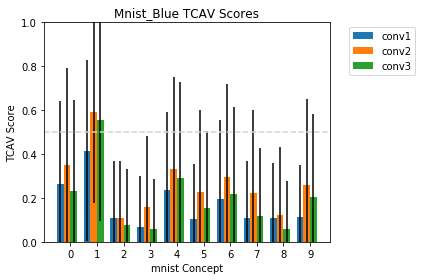

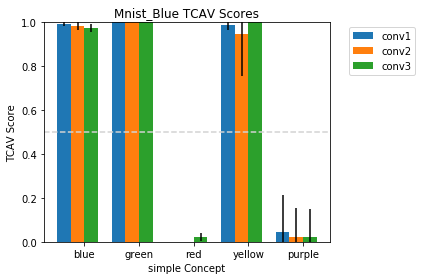

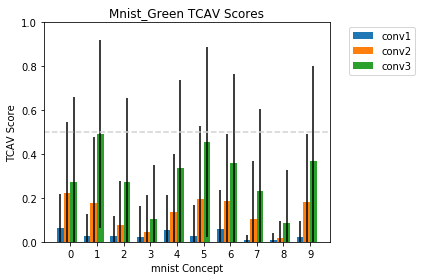

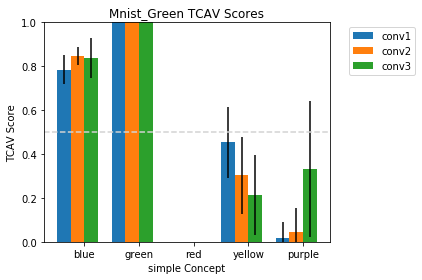

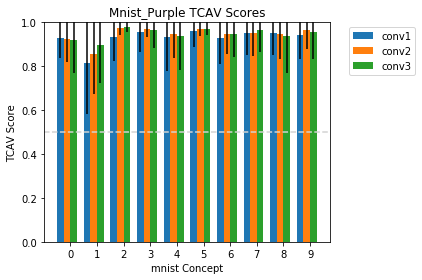

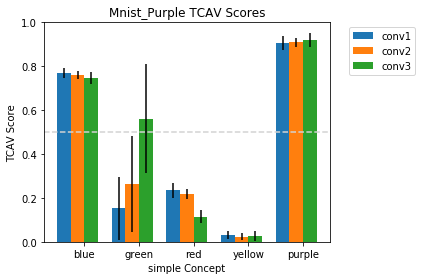

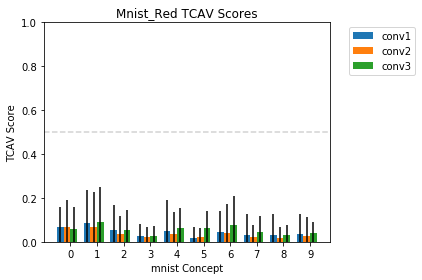

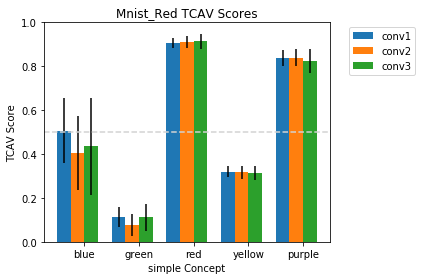

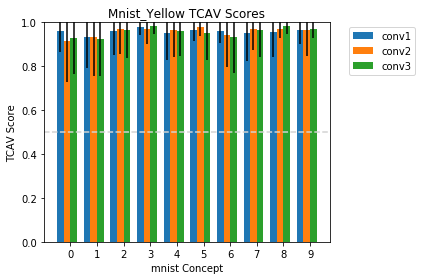

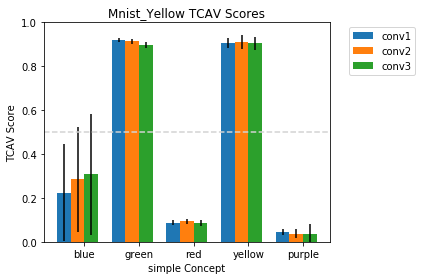

In [24]:
is_bonferroni = False
for results in results_lst:
    utils_plot.plot_concept_results(results, root_dir + 'log/' + project_names + '/plot')

## CAVベクトルの類似度を算出

In [40]:
project_names = '3layer-mnist'
bottlenecks = ['conv1', 'conv2', 'conv3']
concepts = ['mnist_0','mnist_1','mnist_2','mnist_3','mnist_4','mnist_5','mnist_6','mnist_7','mnist_8','mnist_9']
cavs_path = root_dir + 'log/' + project_names + '/cavs'
# cavs_path.sort()
# for path in cavs_path:
#     if keyword == path.split(':')[0]:
#         print(path)
#         cav_path[path.split(':')[0]] = path

In [78]:
# def get_cav_mean(path, bottleneck, concept):
#     cnt = 0
#     for cav_dir in os.listdir(path):
#         if 'cav' in cav_dir:
#             b, _, c = cav_dir.split(':')
#             b = b.split('-')[1]
#             if b == bottleneck and concept in c:
#                 if cnt == 0:
#                     cav_values = np.array(pickle_load(path + '/' + cav_dir))
#                     cav_mean = np.mean(cav_values,0)
#                 else:
#                     cav_values = np.array(pickle_load(path + '/' + cav_dir))
#                     cav_mean += np.mean(cav_values,0)
#                 cnt += 1
#     cav_mean /= cnt
#     return cav_mean

def get_cav_mean(type,path, bottleneck, concept):
    cnt = 0
    for cav_dir in os.listdir(path):
        if cav_dir.split(':')[0] != type:
            continue
        t, c, nc, b = cav_dir.split(':')
        b = b.split('.')[0]
        if b == bottleneck and c == concept:
            if cnt == 0:    
                cav_values = np.array(pickle_load(path + '/' + cav_dir)['cavs'][0])
            else:
                cav_values += np.array(pickle_load(path + '/' + cav_dir)['cavs'][0])
            cnt += 1
    cav_values /= cnt
    return cav_values

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [82]:
mnist_0_cav_mean = get_cav_mean('cav',cavs_path, 'conv1', 'mnist_0')
mnist_1_cav_mean = get_cav_mean('cav',cavs_path, 'conv1', 'mnist_1')

In [84]:
cos_sim(mnist_0_cav_mean,mnist_1_cav_mean)

0.3662365740677491

In [90]:
cos_sim(get_cav_mean('cav',cavs_path, 'conv1', 'simple-yellow'),get_cav_mean('cav',cavs_path, 'conv1', 'simple-green'))
cos_sim(get_cav_mean('cav',cavs_path, 'conv1', 'simple-purple'),get_cav_mean('cav',cavs_path, 'conv1', 'simple-blue'))

0.6453240017054548

In [28]:
cav_dct = {}
t = 'mnist_blue'
conv_shape = (198, 198, 16)
cnt = 0
for cav_dir in os.listdir(cav_path[t]):
    if 'cav' in cav_dir:
        b, _, c = cav_dir.split(':')
        b = b.split('-')[1]
        if b == 'conv1' and 'mnist_0' in c:
            if cnt == 0:
                cav_values = np.array(pickle_load(cav_path[t] + '/' + cav_dir))
                cav_mean = np.mean(cav_values,0)
            else:
                cav_values = np.array(pickle_load(cav_path[t] + '/' + cav_dir))
                cav_mean += np.mean(cav_values,0)
            cnt += 1
print(cnt)
cav_mean /= cnt
cav_mean = cav_mean.reshape(conv_shape)
print(cav_mean.shape)

(198, 198, 16)


In [16]:
p = '/home/tomohiro/code/tcav/log/3layerMnist/cavs/3layerMnist_conv1_conv2_conv3:mnist_yellow:mnist_0_mnist_1_mnist_2_mnist_3_mnist_4_mnist_5_mnist_6_mnist_7_mnist_8_mnist_9_0614/cav-conv1:mnist_yellow:mnist_0_random500_0'
c = np.array(pickle_load(p))
rec = np.reshape(c.reshape(c.shape[0], 198, 198, 16),(50,-1))

In [17]:
c.shape

(50, 627264)

In [18]:
rec.shape

(50, 627264)

In [21]:
(c==rec).all()

True

In [2]:
project_names = '3layerMnist'
bottlenecks = ['conv1', 'conv2', 'conv3']
concepts = ['mnist_0','mnist_1','mnist_2','mnist_3','mnist_4','mnist_5','mnist_6','mnist_7','mnist_8','mnist_9']
acts_path = [root_dir + 'log/' + project_names + '/activations/' + p for p in os.listdir(root_dir + 'log/' + project_names + '/activations')]
acts_path.sort()
print(acts_path[0])

/home/tomohiro/code/tcav/log/3layerMnist/activations/acts_mnist_0_conv1


In [84]:
act = {}
for p in acts_path:
    if bottlenecks[0] in p:
        c = p.split('/')[-1][4+1:-(len(bottlenecks[0])+1)]
        with tf.io.gfile.GFile(p, 'rb') as f:
            act[c] = np.load(f, allow_pickle=True)

In [85]:
act.keys()

dict_keys(['mnist_0', 'mnist_1', 'mnist_2', 'mnist_3', 'mnist_4', 'mnist_5', 'mnist_6', 'mnist_7', 'mnist_8', 'mnist_9', 'mnist_blue', 'mnist_green', 'mnist_purple', 'mnist_red', 'mnist_yellow', 'random500_0', 'random500_10', 'random500_11', 'random500_12', 'random500_13', 'random500_14', 'random500_15', 'random500_16', 'random500_17', 'random500_18', 'random500_19', 'random500_1', 'random500_20', 'random500_21', 'random500_22', 'random500_23', 'random500_24', 'random500_25', 'random500_26', 'random500_27', 'random500_28', 'random500_29', 'random500_2', 'random500_30', 'random500_31', 'random500_32', 'random500_33', 'random500_34', 'random500_35', 'random500_36', 'random500_37', 'random500_38', 'random500_39', 'random500_3', 'random500_40', 'random500_41', 'random500_42', 'random500_43', 'random500_44', 'random500_45', 'random500_46', 'random500_47', 'random500_48', 'random500_49', 'random500_4', 'random500_50', 'random500_51', 'random500_52', 'random500_53', 'random500_54', 'random500

In [111]:
(act['mnist_red'][1] == act['mnist_red'][1]).all()

True

In [117]:
(act['mnist_0'][0] == act['mnist_0'][3]).all()

False

In [7]:
p = '/home/tomohiro/code/tcav/log/3layerMnist/activations/acts_mnist_0_conv1'
with tf.io.gfile.GFile(p, 'rb') as f:
    a = np.load(f, allow_pickle=True)

In [8]:
a.shape

(50, 198, 198, 16)

In [25]:
 [ l['cav_key'] for l in results_lst[1]]

['mnist_0-random500_0:conv1',
 'mnist_1-random500_0:conv1',
 'mnist_2-random500_0:conv1',
 'mnist_3-random500_0:conv1',
 'mnist_4-random500_0:conv1',
 'mnist_5-random500_0:conv1',
 'mnist_6-random500_0:conv1',
 'mnist_7-random500_0:conv1',
 'mnist_8-random500_0:conv1',
 'mnist_9-random500_0:conv1',
 'mnist_0-random500_0:conv2',
 'mnist_1-random500_0:conv2',
 'mnist_2-random500_0:conv2',
 'mnist_3-random500_0:conv2',
 'mnist_4-random500_0:conv2',
 'mnist_5-random500_0:conv2',
 'mnist_6-random500_0:conv2',
 'mnist_7-random500_0:conv2',
 'mnist_8-random500_0:conv2',
 'mnist_9-random500_0:conv2',
 'mnist_0-random500_0:conv3',
 'mnist_1-random500_0:conv3',
 'mnist_2-random500_0:conv3',
 'mnist_3-random500_0:conv3',
 'mnist_4-random500_0:conv3',
 'mnist_5-random500_0:conv3',
 'mnist_6-random500_0:conv3',
 'mnist_7-random500_0:conv3',
 'mnist_8-random500_0:conv3',
 'mnist_9-random500_0:conv3']